## Investigating How Housing Value Correlates with SAT Scores in New York City
- Author: John Mays
- For: NYC Mayor's Office of Management and Budget
### Setup:

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
mpl.rcParams['figure.dpi'] = 100

### Importing Data:

In [3]:
prices = pd.concat([pd.read_excel('../data/2010_queens.xls', header=3),
                    pd.read_excel('../data/2010_bronx.xls', header=3),
                    pd.read_excel('../data/2010_brooklyn.xls', header=3),
                    pd.read_excel('../data/2010_manhattan.xls', header=3),
                    pd.read_excel('../data/2010_statenisland.xls', header=3)
                    ])

SAT_scores = pd.read_csv('../data/SAT__College_Board__2010_School_Level_Results_20231216.csv')

high_schools = pd.read_csv('../data/2014_-_2015_DOE_High_School_Directory_20231216.csv')

zip_boundaries = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA)_20231216.geojson')

In [4]:
residential_building_class_categories = [
   '01  ONE FAMILY HOMES                        ',
   '02  TWO FAMILY HOMES                        ',
   '03  THREE FAMILY HOMES                      ',
   '12  CONDOS - WALKUP APARTMENTS              ',
   '04  TAX CLASS 1 CONDOS                      ',
   '07  RENTALS - WALKUP APARTMENTS             ',
   '08  RENTALS - ELEVATOR APARTMENTS           ',
   '09  COOPS - WALKUP APARTMENTS               ',
   '10  COOPS - ELEVATOR APARTMENTS             ',
   '13  CONDOS - ELEVATOR APARTMENTS            '
]

### Cleaning & Formatting Data:

In [5]:
prices = prices[prices['BUILDING CLASS CATEGORY'].isin(residential_building_class_categories)]
prices = prices[['ZIP CODE', 'SALE PRICE']]
prices = prices[prices['SALE PRICE']!=0]
mean_prices = prices.groupby('ZIP CODE').mean()
median_prices = prices.groupby('ZIP CODE').median()

In [6]:
high_schools.rename({'dbn': 'DBN', 'postcode': 'ZIP CODE'}, axis=1, inplace=True)
high_schools = high_schools[['DBN', 'ZIP CODE']]

In [7]:
zip_boundaries = zip_boundaries[['modzcta', 'geometry']]
zip_boundaries.rename({'modzcta': 'ZIP CODE'}, axis=1, inplace=True)
zip_boundaries['ZIP CODE'] = zip_boundaries['ZIP CODE'].astype('int64')

### Merging into one DataFrame indexed by ZIP Code:
#### Creating a DataFrame with Mean SAT Score by ZIP Code:

In [8]:
SAT_with_ZIP = SAT_scores.join(high_schools.set_index('DBN'), on='DBN', how='inner')
SAT_with_ZIP['Critical Reading Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Mathematics Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Writing Mean'] *= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP = SAT_with_ZIP.dropna()
SAT_with_ZIP = SAT_with_ZIP[['Number of Test Takers', 'Critical Reading Mean',
                            'Mathematics Mean', 'Writing Mean', 'ZIP CODE']]
SAT_with_ZIP = SAT_with_ZIP.groupby('ZIP CODE').sum()
SAT_with_ZIP['Critical Reading Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Mathematics Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['Writing Mean'] /= SAT_with_ZIP['Number of Test Takers']
SAT_with_ZIP['SAT Score Mean'] = (SAT_with_ZIP['Critical Reading Mean'] +
                                  SAT_with_ZIP['Mathematics Mean'] +
                                  SAT_with_ZIP['Writing Mean'])/3
SAT_with_ZIP = SAT_with_ZIP['SAT Score Mean']

The code above implemented this formula and stored the output in a dataframe (indexed by ZIP):

$$score\_mean_{zip} = \sum_{school \in zip}\frac{reading\_mean_{school} + math\_mean_{school} + writing\_mean_{school}}{3 \times num\_test\_takers_{school}}$$

In [9]:
SAT_with_ZIP.head()

ZIP CODE
10002    471.470653
10003    442.738025
10004    456.784615
10006    451.923077
10009    417.000000
Name: SAT Score Mean, dtype: float64

#### Merging Zip Boundaries with Mean Housing Prices:

In [10]:
boundaries_with_prices = zip_boundaries.set_index('ZIP CODE').join(median_prices, on='ZIP CODE', how='inner')

In [11]:
boundaries_with_prices.head()

,geometry,SALE PRICE
ZIP CODE,,
10001,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ...",1200000.0
10002,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ...",610000.0
10003,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",996500.0
10026,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",645000.0
10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",722957.0


#### Total Merge:

In [12]:
total_df = boundaries_with_prices.join(SAT_with_ZIP, how = 'inner', on = 'ZIP CODE')

In [13]:
total_df.head()

,geometry,SALE PRICE,SAT Score Mean
ZIP CODE,,,
10002,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ...",610000.0,471.470653
10003,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",996500.0,442.738025
10026,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",645000.0,385.313531
10004,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",722957.0,456.784615
10006,"MULTIPOLYGON (((-74.01251 40.70677, -74.01325 ...",529000.0,451.923077


In [14]:
print(f'No. of ZIP Codes with SAT Scores: {SAT_with_ZIP.shape[0]}')
print(f'No. of ZIP Codes with Residential Sales Data: {boundaries_with_prices.shape[0]}')
print(f'No. of ZIPs left after inner join: {total_df.shape[0]}')

No. of ZIP Codes with SAT Scores: 108
No. of ZIP Codes with Residential Sales Data: 176
No. of ZIPs left after inner join: 108


Quite a few of the zip codes in NYC were lost after the join that was just performed.  All of them had at least some residential living spaces to gather housing price from, but many did not have even one high school.

### Analysis and Figures:

In [15]:
inferno = plt.cm.inferno

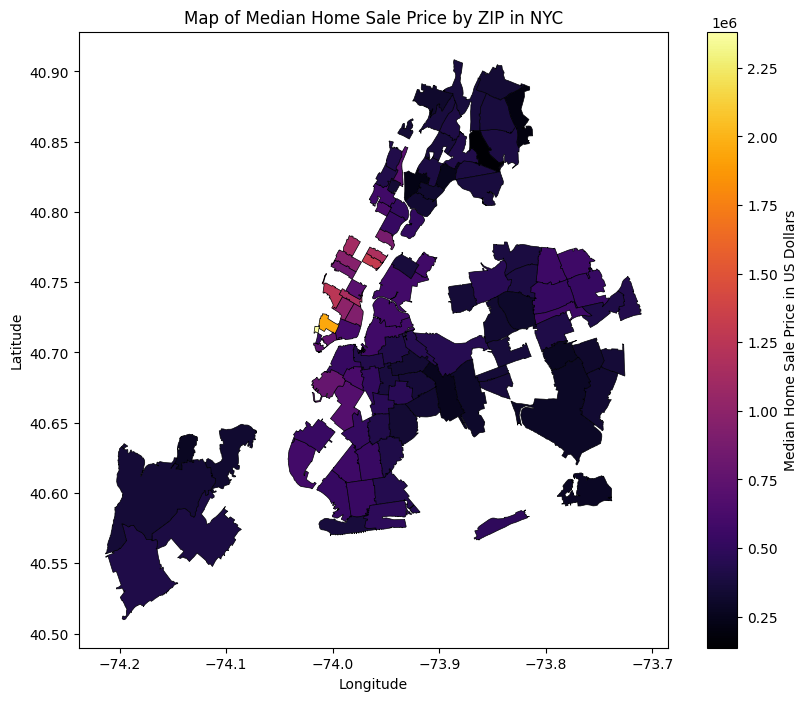

In [16]:
fig, ax = plt.subplots(1, figsize = (10, 8))
ax = total_df.plot(column='SALE PRICE', cmap=inferno, ax=ax,
                   edgecolor = inferno(0), linewidth = 0.5)
plt.colorbar(
    plt.cm.ScalarMappable(cmap=inferno, norm=plt.Normalize(
        vmin=total_df['SALE PRICE'].min(),
        vmax=total_df['SALE PRICE'].max())),
        ax = ax, label = 'Median Home Sale Price in US Dollars')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Median Home Sale Price by ZIP in NYC')
plt.show();

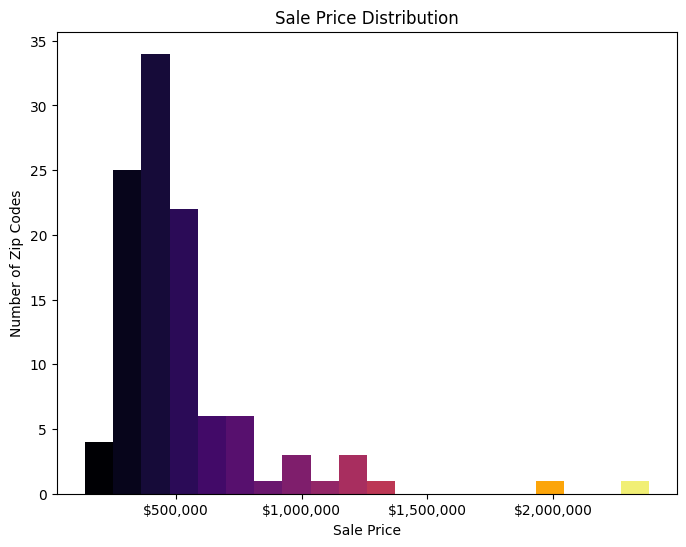

In [17]:
fig, ax = plt.subplots(1, figsize = (8, 6))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
N, bins, patches = ax.hist(total_df['SALE PRICE'], bins=20)

fracs = bins / bins.max()
norm = mpl.colors.Normalize(fracs.min(), fracs.max())
for frac, patch in zip(fracs, patches):
    color = inferno(norm(frac))
    patch.set_facecolor(color)

plt.ylabel('Number of Zip Codes')
plt.xlabel('Sale Price')
plt.title('Sale Price Distribution')
plt.show();

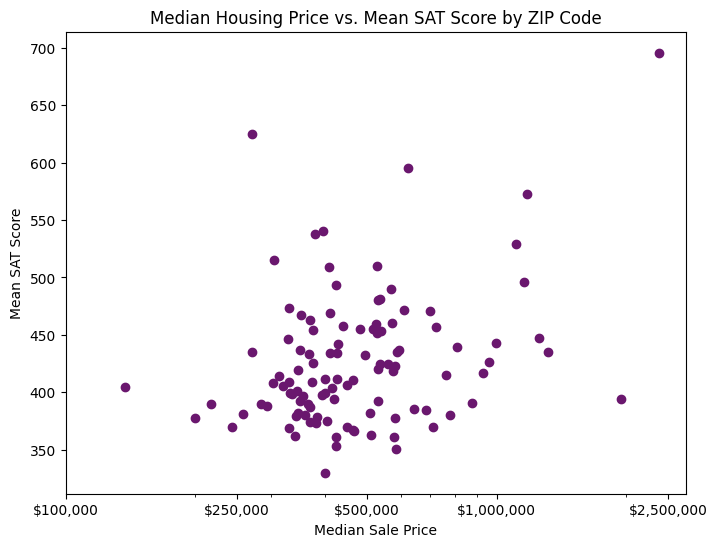

In [18]:
fig, ax = plt.subplots(1, figsize = (8, 6))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.scatter(total_df['SALE PRICE'], total_df['SAT Score Mean'], color=inferno(0.3))
plt.ylabel('Mean SAT Score')
plt.xlabel('Median Sale Price')
plt.xscale('log')
ticks = [1.e+05, 2.5e+05, 5.e+05, 1.e+06, 2.5e+06]
plt.xticks(ticks = ticks, labels=map(lambda x: f'${x:,.0f}', ticks))
plt.title('Median Housing Price vs. Mean SAT Score by ZIP Code')
plt.show();